In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

In [3]:
df_train = pd.read_pickle("df_train.pkl")
df_validation = pd.read_pickle("df_validation.pkl")
df_test = pd.read_pickle("df_test.pkl")
df_price = pd.read_pickle("df_price.pkl")
df_option = pd.read_pickle("df_merged.pkl")

### **This notebook aims to perform exploratory analyses. It serves as a space for prototyping and experimentation. The code here is not meant for production use but is intended to inspire and guide me in designing robust strategies.**

----

----

## **FOUNDATION**

PRICER

In [4]:
def black_scholes_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)* T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put_price(S, K, T, r, sigma):
    if T <= 0:
        return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def black_scholes_call_delta(S, K, T, r, sigma):
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_put_delta(S, K, T, r, sigma):
    if T <= 0:
        return -1.0 if S < K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1 

Backtester function

In [5]:
    def get_rows_price_date(date1,date2):
        '''This function retrieves from the DataFrame the spot prices for the 
        dates between date1 and date2.
        
        RETURNS
        -------
        type : pandas.core.frame.DataFrame
        '''
        filtered = df_price[(df_price['Date'] >= date1) & (df_price['Date'] <= date2)]
        return filtered

In [6]:
def run_gamma_scalping(straddle_row):
    '''

    PARAMETERS
    ----------
    straddle_row : 
        pandas.core.series.Series
    '''
    res = {}

    PNL_evolution = [] # evolution of the pnl at each time step of the delta hedging
    hedge_gain = []

    Straddle_t0 = straddle_row['Straddle']

    df_prices_lifetime = get_rows_price_date(straddle_row['Date'],straddle_row[' [EXPIRE_DATE]']) # We retrieve the df of the spot prices associated to the lifetime of the straddle

    # avoid splited stock problem
    if straddle_row['Date'] <= " 2020-07-31":
        date_to_price = dict(zip(df_prices_lifetime['Date'], df_prices_lifetime['Price_unsplited'])) # We create the dictionnary of date and associated unsplited price
    elif straddle_row['Date'] >= " 2020-09-01":
        date_to_price = dict(zip(df_prices_lifetime['Date'], df_prices_lifetime['Price'])) # We create the dictionnary of date and associated price
    else:
        return {'PNL':0, 'price_strad':0, 'gross_gain':0} 


    list_date = list(date_to_price.keys())

    r = 0.03
    iv_call = straddle_row[' [C_IV]']
    iv_put = straddle_row[' [P_IV]']

    # Hedging part
    for i in range(1, len(date_to_price)):
        S_tbefore = date_to_price[list_date[i-1]]
        S_t = date_to_price[list_date[i]]

        time_to_maturity_before = (len(list_date) - (i - 1)) / 252
        time_to_maturity = (len(list_date) - i) / 252

        C_tbefore = black_scholes_call_price(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_call)
        C_t = black_scholes_call_price(S_t, straddle_row[' [STRIKE]'], time_to_maturity, r, iv_call)
        P_tbefore = black_scholes_put_price(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_put)
        P_t = black_scholes_put_price(S_t, straddle_row[' [STRIKE]'], time_to_maturity, r, iv_put)

        Straddle_before = C_tbefore + P_tbefore
        Straddle_t = C_t + P_t

        delta_call_t = black_scholes_call_delta(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_call)
        delta_put_t = black_scholes_put_delta(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_put)

        hedge_value = (-delta_call_t * (S_t - S_tbefore) +
                    (delta_call_t * S_tbefore - C_tbefore) * (np.exp(r * (1/252)) - 1)
                    - delta_put_t * (S_t - S_tbefore) +
                    (delta_put_t * S_tbefore - P_tbefore) * (np.exp(r * (1/252)) - 1))

        hedge_gain.append(hedge_value)

        pnl_total_t = (Straddle_t - Straddle_t0) + np.sum(hedge_gain[:i])
        PNL_evolution.append(pnl_total_t)
    
    res['PNL'] = PNL_evolution[-1]
    res['price_strad'] = Straddle_t0
    res['gross_gain'] = PNL_evolution[-1] + Straddle_t0

    return res

In [7]:
def run_backtest(df_backtest, strategy):
    PNL = 0
    Investment_capital = 0
    df_filtered = df_backtest[df_backtest['Date'] > " 2016-03-01"]
    for _, row in df_filtered.iterrows():
        trade_signal = "SKIP"
        if strategy.should_trade(row):
            signal = strategy.get_signal(row)
            res = run_gamma_scalping(row)
            if signal == 'LONG' :
                PNL += res['PNL']
                trade_signal = 'LONG'
            else : # If signal == 'SHORT'
                PNL += -res['PNL']
                trade_signal = 'SHORT'                
            Investment_capital += res['price_strad']
        #print(f"Date:{row['Date']}, PNL:{PNL}, Decision to trade:{trade_signal}")
    
    print(f"PNL:{PNL}, ROI:{(PNL/Investment_capital)*100} %")
        return res

IndentationError: unexpected indent (3122583711.py, line 20)

-----

----

## Evolution of IV and RV for each straddle

The following charts show the evolution of IV and RV for each straddle in df_train over time. For the same date, there can be multiple straddles because maturities may differ.

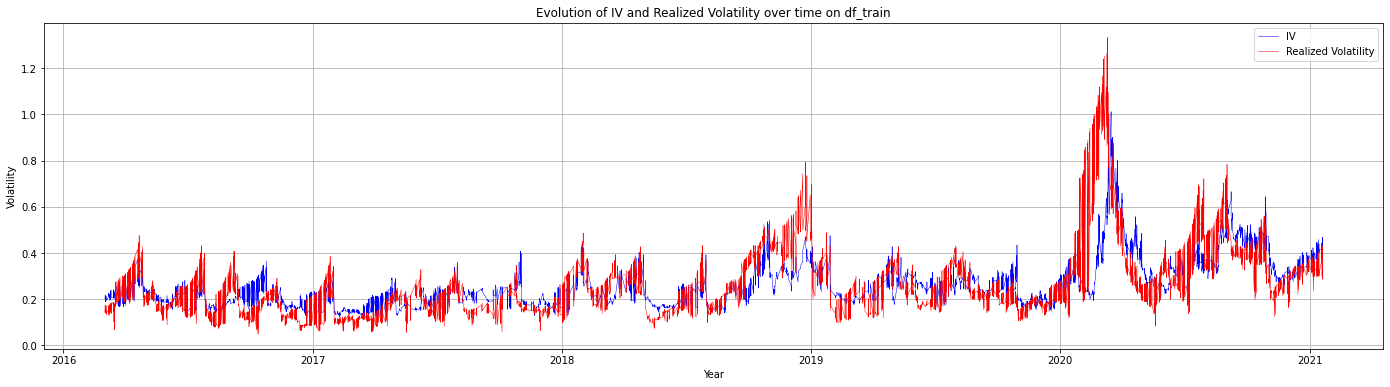

In [ ]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['IV'], linewidth=0.5, color='blue', label='IV')
plt.plot(df_filtered['Date'], df_filtered['vol_real'], linewidth=0.5, color='red', label='Realized Volatility')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('Evolution of IV and Realized Volatility over time on df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


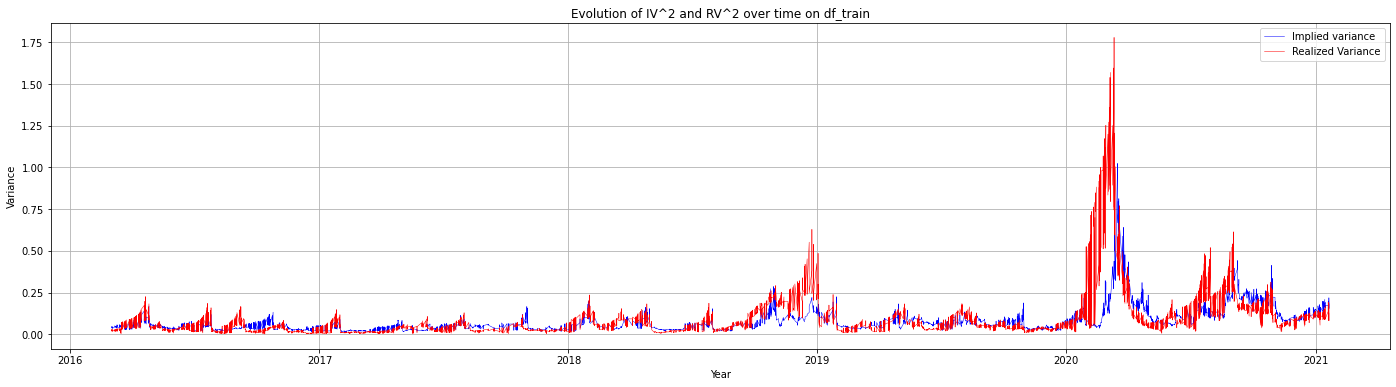

In [40]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['IV']**2, linewidth=0.5, color='blue', label='Implied variance')
plt.plot(df_filtered['Date'], df_filtered['vol_real']**2, linewidth=0.5, color='red', label='Realized Variance')
plt.xlabel('Year')
plt.ylabel('Variance')
plt.title('Evolution of IV^2 and RV^2 over time on df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

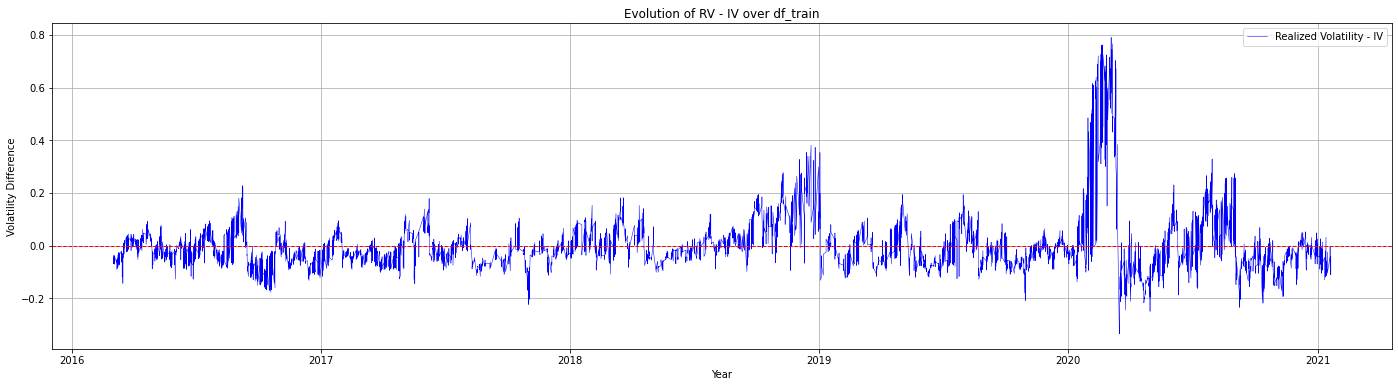

In [ ]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['vol_real'] - df_filtered['IV'], linewidth=0.5, color='blue', label='Realized Volatility - IV')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility Difference')
plt.title('Evolution of RV - IV over df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


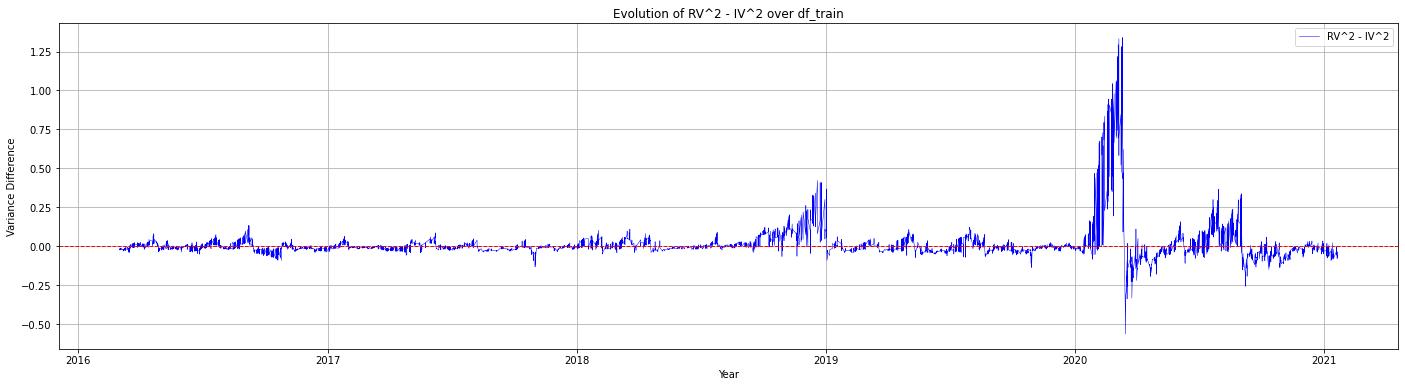

In [39]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['vol_real']**2 - df_filtered['IV']**2, linewidth=0.5, color='blue', label='RV^2 - IV^2')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Variance Difference')
plt.title('Evolution of RV^2 - IV^2 over df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


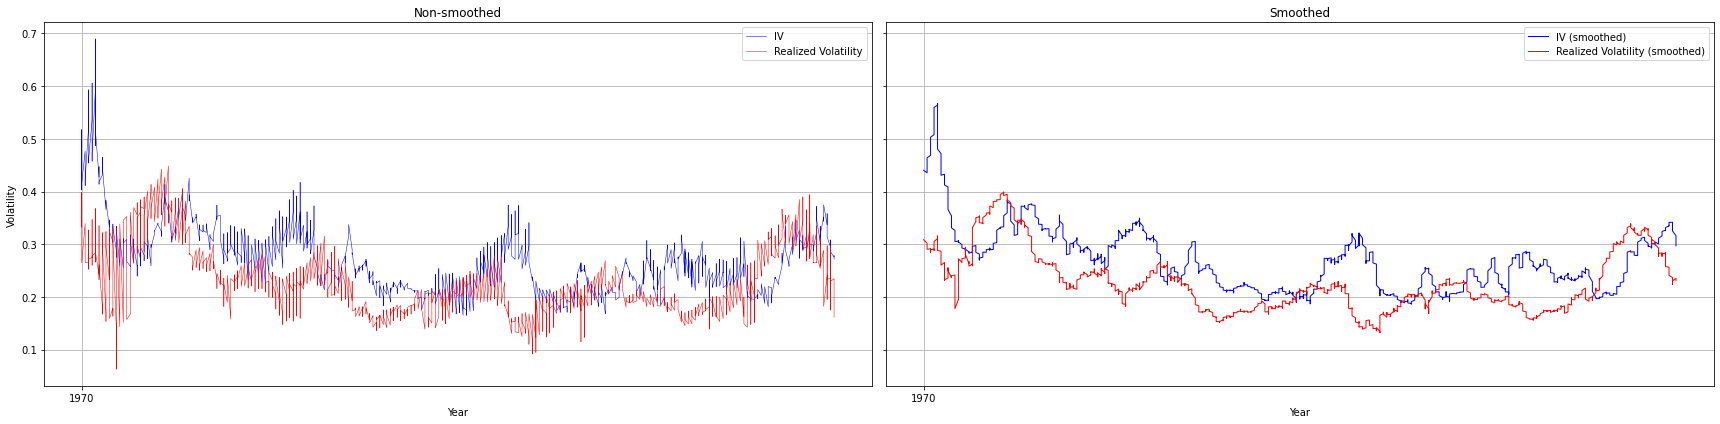

In [8]:
window = 10
df_validation['IV_smooth'] = df_validation['IV'].rolling(window=window, center=True).mean()
df_validation['vol_real_smooth'] = df_validation['vol_real'].rolling(window=window, center=True).mean()

fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)


axes[0].plot(df_validation['Date'], df_validation['IV'], linewidth=0.5, color='blue', label='IV')
axes[0].plot(df_validation['Date'], df_validation['vol_real'], linewidth=0.5, color='red', label='Realized Volatility')
axes[0].set_title('Non-smoothed')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Volatility')
axes[0].legend()
axes[0].grid(True)
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


axes[1].plot(df_validation['Date'], df_validation['IV_smooth'], linewidth=1, color='blue', label='IV (smoothed)')
axes[1].plot(df_validation['Date'], df_validation['vol_real_smooth'], linewidth=1, color='red', label='Realized Volatility (smoothed)')
axes[1].set_title('Smoothed')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True)
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


The following charts show, for 50 randomly selected dates from df_train, the IV and RV of straddles as a function of days to maturity.

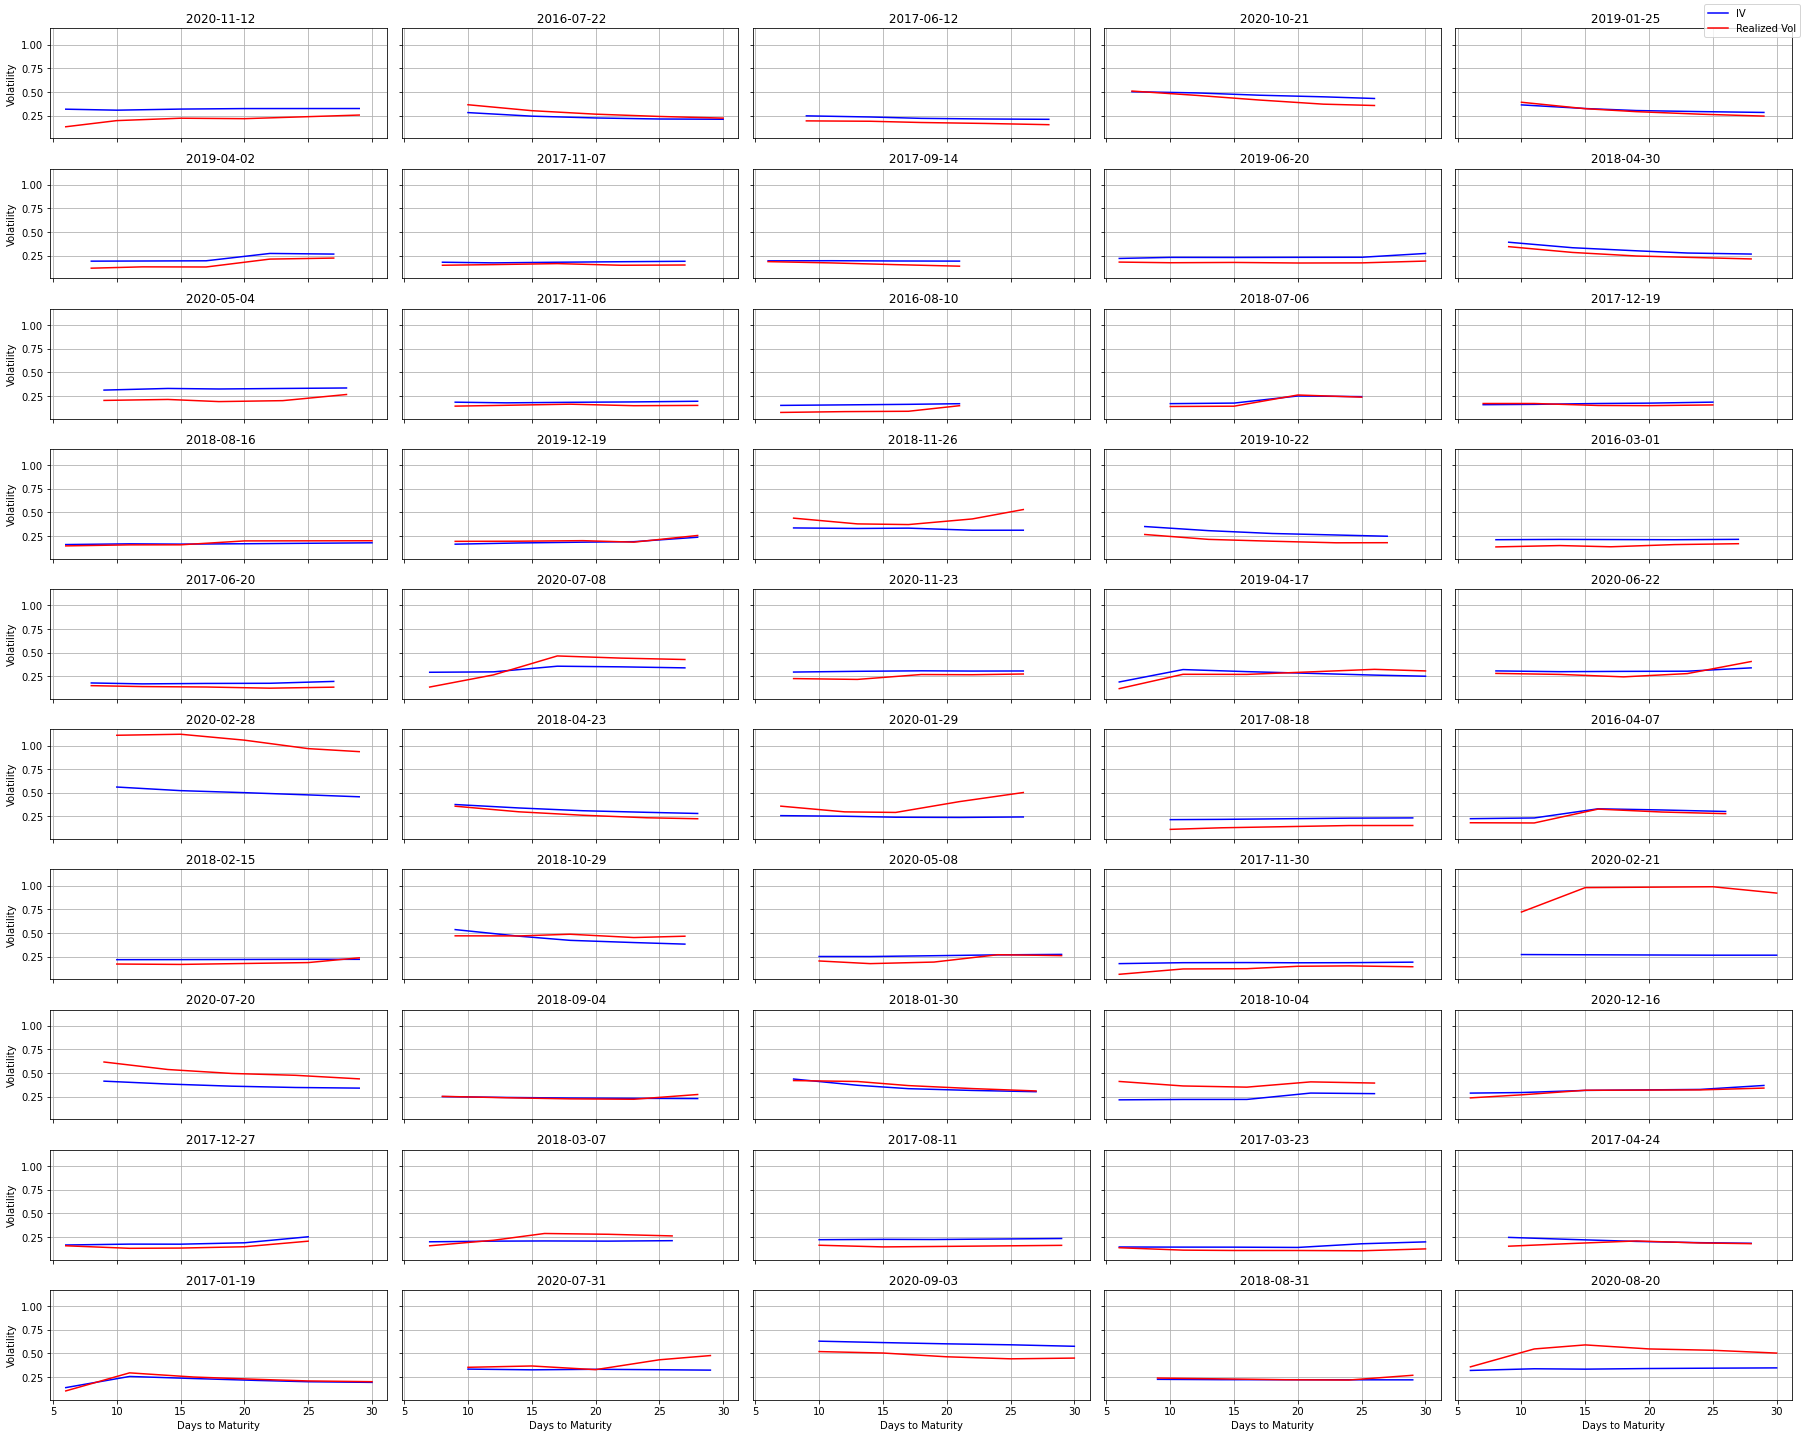

In [9]:
df_mean = df_train.groupby(["Date", "day_to_maturity"])[["IV", "vol_real"]].mean().reset_index()
dates_sample = np.random.choice(df_mean['Date'].unique(), size=50, replace=False)

n_rows = 10
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20), sharex=True, sharey=True)
axes = axes.flatten()

for i, date in enumerate(dates_sample):
    subset = df_mean[df_mean['Date'] == date]
    axes[i].plot(subset['day_to_maturity'], subset['IV'], color='blue', label='IV')
    axes[i].plot(subset['day_to_maturity'], subset['vol_real'], color='red', label='Realized Vol')
    axes[i].set_title(str(date))
    axes[i].grid(True)
    if i % n_cols == 0:
        axes[i].set_ylabel("Volatility")
    if i >= (n_rows-1)*n_cols:
        axes[i].set_xlabel("Days to Maturity")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

----

## GARCH and notion of volatility

Let's say $X_t$ the log-return process with $\mathbb{E}[X_t] = 0$ and $\mathbb{V}[X_t] = \sigma^2$. By definition, the volatility is $\sigma$.

Given a statistical series ($X_1, X_2, \dots, X_n$) the empirical estimator for the $volatility^2$ is :

$ \hat{\sigma}^2 = \frac{1}{n} \sum_{t=1}^{n} \big(X_t - \bar{X})^2 $ with $\bar{X} \approx 0$



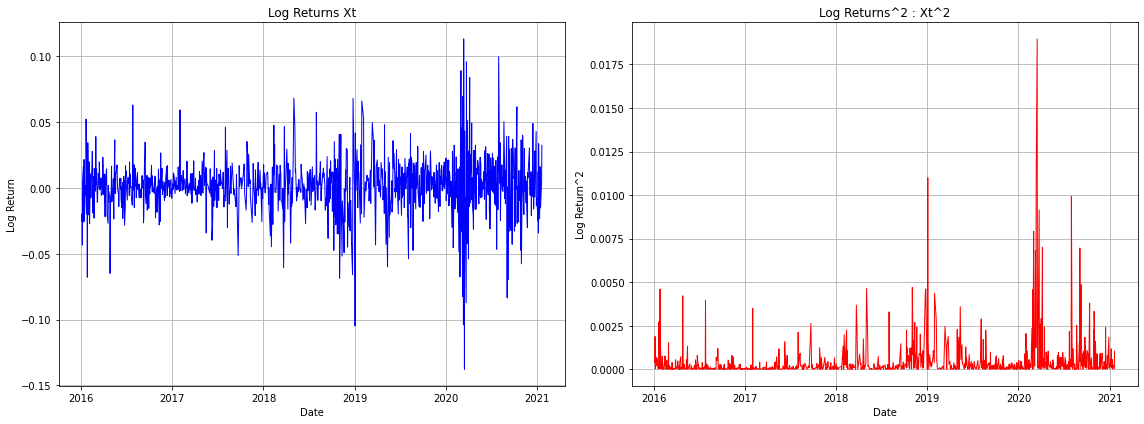

In [10]:
# log returns of df_train
mask = df_price['Date'].isin(df_train['Date'])
df_filtered = df_price[mask]
log_returns = np.log(df_filtered['Price']).diff()
log_returns_squared = log_returns**2

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)
axes[0].plot(pd.to_datetime(df_filtered['Date']), log_returns, color='blue', linewidth=1)
axes[0].set_title('Log Returns Xt')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Log Return')
axes[0].grid(True)

axes[1].plot(pd.to_datetime(df_filtered['Date']), log_returns_squared, color='red', linewidth=1)
axes[1].set_title('Log Returns^2 : Xt^2')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Return^2')
axes[1].grid(True)

plt.tight_layout()
plt.show()

To give us an idea of the volatility of the log-return, we study the plot of the squared series. Indeed,
squaring the series effectively captures its variance.
We observe that periods of high volatility are followed by periods of low volatility.


INTERPRETATION : One can suspect conditional heteroskedasticity in the series, in other words,
the conditional variance is not constant over time. Thus, the most relevant model to fit appears to be a **GARCH** model (Generalized autoregressive conditional heteroscedastic).

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model can be written as:

$$
X_t = \sigma_t \epsilon_t
$$

$$
\sigma_t^2 = \omega + \alpha_1 X_{t-1}^2 + \dots + \alpha_p X_{t-p}^2 + \beta_1 \sigma_{t-1}^2 + \dots + \beta_q \sigma_{t-q}^2
$$

where:

- $X_t$ is the log-return process at time $t$  
- $\sigma_t^2$ is the conditional variance at time $t$  
- $\omega$ is the constant term  
- $\alpha_i$ are the ARCH coefficients (effects of past squared values)  
- $\beta_j$ are the GARCH coefficients (effects of past conditional variances)  
- $\epsilon_t$ is a standard Gaussian white noise at time $t$


Under GARCH assumption, $\mathbb{V}[X_t|\mathcal{F}_{t-1}] = \sigma^2_t$

In other words, $\sigma^2_t$ is the instantaneous variance of $X_t$ **at time t** given the past. 

So, to compute the annualized volatility over a given period, we should calculate the arithmetic average of the daily volatilities $\sigma_t \ \forall t \in\ period$ during that period given by **GARCH**, then multiply it by the square root of 252.

**EXAMPLE** :
For a period = week of 5 trading days :

$$volatility = \frac{1}{5}\sum_{t=1}^{5} \sigma_t $$
$$\sigma_{annualized} = volatility * \sqrt{252}$$



**PROOF** : 

considering the following filtration : $\mathcal{F}_t = \sigma((X_s)_{s\le t})$ we have :
$$\mathbb{V}[X_t|\mathcal{F}_{t-1}] = \mathbb{E}[(X_t - \mathbb{E}[X_t|\mathcal{F}_{t-1}])^2|\mathcal{F}_{t-1}] = \mathbb{E}[X^2_{t}|\mathcal{F}_{t-1}] - \mathbb{E}[X_t|\mathcal{F}_{t-1}]^2 = \mathbb{E}[X^2_{t}|\mathcal{F}_{t-1}]$$

With $\mathbb{E}[X_t|\mathcal{F}_{t-1}] = \mathbb{E}[\sigma_t \epsilon_t | \mathcal{F}_{t-1}] = \mathbb{E}[\epsilon_t]\mathbb{E}[\sigma_t|\mathcal{F}_{t-1}] = 0$
Beacause, $\sigma_t$ and $\epsilon_t$ are independent. 


Then we have : 
$$\mathbb{E}[X^2_{t}|\mathcal{F}_{t-1}] = \mathbb{E}[\sigma^2_t\ \epsilon^2_t | \mathcal{F}_{t-1}] = \sigma^2_t \mathbb{E}[\epsilon^2_t|\mathcal{F}_{t-1}] =  \sigma^2_t\ \mathbb{E}[\epsilon^2_t] = \sigma^2_t$$
Because $\sigma^2_t$ is mesurable for the $\mathcal{F}_{t-1}$ $\sigma$-algebra and $\epsilon_t$ is independant of the $\mathcal{F}_{t-1}$ $\sigma$-algebra.

In [11]:
from arch import arch_model

In [50]:
df_filtered = df_price[df_price['Date'].isin(df_train['Date'].unique())].copy()

In [48]:
df_train['Date'].iloc[0]

' 2016-01-04'

In [51]:
df_filtered['Date'].iloc[0]

' 2016-01-04'

In [57]:
df_filtered.shape

(1103, 9)

In [91]:
log_returns = np.log(df_filtered['Price'] / df_filtered['Price'].shift(1)).dropna() * 100  # in %

# Find the best GARCH(p,q) model using AIC
best_aic = np.inf
best_order = None
results = {}

for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = arch_model(log_returns, vol='Garch', p=p, q=q)
            res = model.fit(disp='off')
            results[(p, q)] = res.aic
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, q)
        except:
            continue

print("Best order (p,q):", best_order, "with AIC =", best_aic)

# Optional: print AIC for all tested (p,q)
print("AIC for each (p,q) tried:")
for k, v in results.items():
    print(f"p={k[0]}, q={k[1]} -> AIC={v:.2f}")

Best order (p,q): (2, 1) with AIC = 4392.734346849402
AIC for each (p,q) tried:
p=1, q=0 -> AIC=4603.33
p=1, q=1 -> AIC=4395.60
p=1, q=2 -> AIC=4397.60
p=1, q=3 -> AIC=4399.60
p=2, q=0 -> AIC=4520.04
p=2, q=1 -> AIC=4392.73
p=2, q=2 -> AIC=4394.28
p=2, q=3 -> AIC=4396.28
p=3, q=0 -> AIC=4436.78
p=3, q=1 -> AIC=4393.87
p=3, q=2 -> AIC=4395.87
p=3, q=3 -> AIC=4397.26


The GARCH(1,1) model is defined as:

$$
X_t = \sigma_t \epsilon_t
$$

$$
\sigma_t^2 = \omega + \alpha_1 X_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

where:

- $X_t$ is the process at time $t$  
- $\sigma_t^2$ is the conditional variance at time $t$  
- $\omega$ is the constant term  
- $\alpha_1$ is the ARCH(1) coefficient (effect of past squared value)  
- $\beta_1$ is the GARCH(1) coefficient (effect of past variance)  
- $\epsilon_t$ is a standard Gaussian white noise at time $t$


In [87]:
best_model = arch_model(log_returns, vol='Garch', p=2, q=1) # We instantiate the GARCH class.

best_res = best_model.fit(disp='off')
print(best_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4622.25
Distribution:                  Normal   AIC:                           9254.50
Method:            Maximum Likelihood   BIC:                           9283.43
                                        No. Observations:                 2408
Date:                Wed, Aug 20 2025   Df Residuals:                     2407
Time:                        11:49:19   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1566  3.339e-02      4.690  2.731e-06 [9.115e-0

From the P-VALUE column, we can see that all the coefficients are significant at more than 99% instead of alpha[2] So we will retain the GARCH(1,1).

In [88]:
df_price['Date'].iloc[0]

' 2016-01-04'

In [93]:
best_model = arch_model(log_returns, vol='Garch', p=1, q=1) # We instantiate the GARCH class.
best_res = best_model.fit(disp='off')

- ***best_res.conditional_volatility*** calculates the 1-day ahead predicted conditional volatility using past realized log returns.

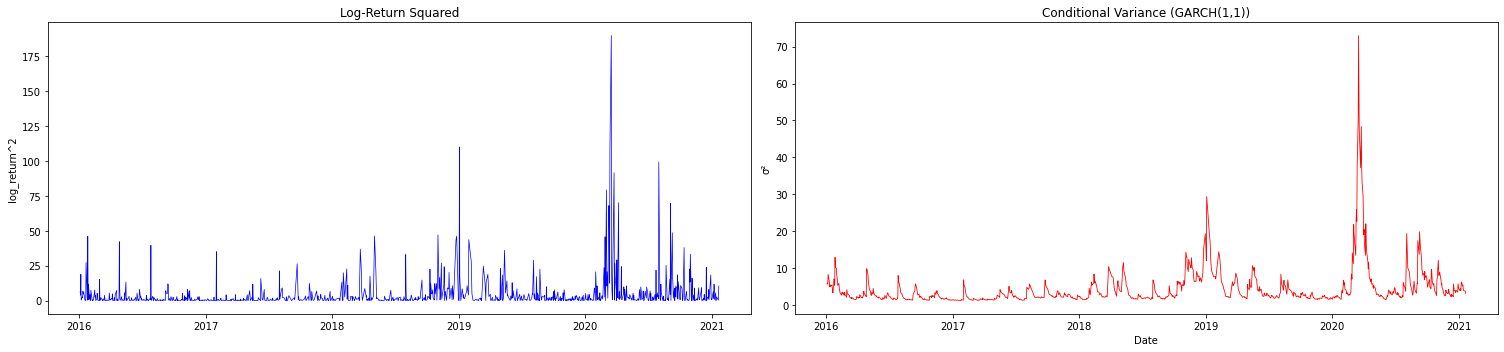

In [94]:
# log_return^2
log_return2 = (np.log(df_filtered['Price'] / df_filtered['Price'].shift(1)).dropna() * 100)**2
log_return2 = pd.Series(log_return2.values, index=pd.to_datetime(df_filtered['Date'].iloc[-len(log_return2):]))

# Conditional variance from GARCH
cond_vol = (best_res.conditional_volatility)**2
cond_vol = pd.Series(cond_vol.values, index=pd.to_datetime(df_filtered['Date'].iloc[-len(cond_vol):]))

fig, axs = plt.subplots(1, 2, figsize=(21,5), sharex=True)

axs[0].plot(log_return2, color='blue', linewidth=0.7)
axs[0].set_title("Log-Return Squared")
axs[0].set_ylabel("log_return^2")
axs[1].plot(cond_vol, color='red', linewidth=0.8)
axs[1].set_title("Conditional Variance (GARCH(1,1))")
axs[1].set_ylabel("σ²")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

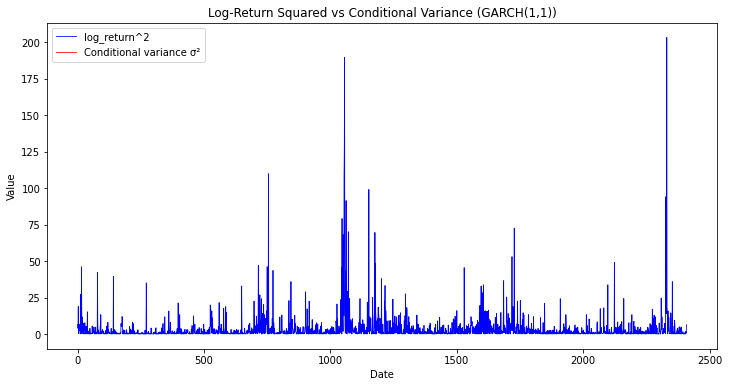

In [78]:
# Réindexer cond_vol pour correspondre à log_return2
cond_vol_aligned = cond_vol.reindex(log_return2.index)

plt.figure(figsize=(12,6))
plt.plot(log_return2, label='log_return^2', color='blue', linewidth=0.8)
plt.plot(cond_vol_aligned, label='Conditional variance σ²', color='red', linewidth=0.8)
plt.title("Log-Return Squared vs Conditional Variance (GARCH(1,1))")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


In [43]:
forecast = best_res.forecast(horizon=5)
print(forecast.variance[-1:])

           h.1       h.2      h.3       h.4       h.5
1270  4.170689  4.184721  4.19799  4.210537  4.222403
